In [1]:
# 0 define backend
import sys, os, time

# %env DDE_BACKEND=tensorflow.compat.v1
# %env XLA_FLAGS=--xla_gpu_cuda_data_dir=/usr/local/home/cyan3/miniforge/envs/tf

os.environ['DDE_BACKEND'] = "pytorch" # v2
os.environ['XLA_FLAGS'] = "--xla_gpu_cuda_data_dir=/usr/local/home/cyan3/miniforge/envs/tf"

# https://stackoverflow.com/questions/68614547/tensorflow-libdevice-not-found-why-is-it-not-found-in-the-searched-path
# this directory has /nvvm/libdevice/libdevice.10.bc

print(os.environ['DDE_BACKEND'])

pytorch


In [2]:
# import tensorflow as tf
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')
# for device in gpu_devices:
#     print(device)

import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.current_device())
torch.cuda.set_device(0)

# https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
torch.jit.enable_onednn_fusion(True)

cuda0 = torch.device('cuda:0')
cpu = torch.device('cpu')

import deepxde as dde
import numpy as np
from numpy import linalg as LA
import math

import matplotlib.pyplot as plt
import pylab

from os.path import dirname, join as pjoin

from scipy import stats
import scipy.io
from scipy.stats import truncnorm, norm
from scipy.optimize import linprog
from scipy import sparse
from scipy.stats import multivariate_normal

if dde.backend.backend_name == "pytorch":
    exp = dde.backend.torch.exp
else:
    from deepxde.backend import tf

    exp = tf.exp
    
import cvxpy as cp
import numpy as np
import tensorflow as tf
from scipy.linalg import solve_discrete_are
from scipy.linalg import sqrtm

# from cvxpylayers.tensorflow.cvxpylayer import CvxpyLayer
from cvxpylayers.torch import CvxpyLayer

print(time.time())

Using backend: pytorch



True
1
NVIDIA RTX A2000 Laptop GPU
11.3
True
0


2022-09-11 20:08:55.643084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-11 20:08:55.730719: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-11 20:08:55.750601: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-11 20:08:56.085419: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

1662952136.49321


In [4]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [5]:
N = nSample = 50

# must be floats
state_min = 0.0
state_max = 6.0

mu_0 = 1.0
sigma_0 = 1.0

mu_T = 3.0
sigma_T = 1.0

j1, j2, j3 =1,1,2 # axis-symmetric case
q_statepenalty_gain = 0 # 0.5

T_0=0. #initial time
T_t=200. #Terminal time

x_grid = np.transpose(np.linspace(state_min, state_max, nSample))
y_grid = np.transpose(np.linspace(state_min, state_max, nSample))
[X,Y] = np.meshgrid(x_grid,x_grid)
C = (X - Y)**2

# cvector = C.flatten('F')
cvector = C.reshape(nSample**2,1)

A = np.concatenate(
    (
        np.kron(
            np.ones((1,nSample)),
            sparse.eye(nSample).toarray()
        ),
        np.kron(
            sparse.eye(nSample).toarray(),
            np.ones((1,nSample))
        )
    ), axis=0)
# 2*nSample

id_prefix = nb_name.replace(".ipynb", "").replace("-", "_")

print(id_prefix)
print(time.time())

wass_1d_torch_scratch0
1662952141.1468675


In [6]:
def pdf1d(x, mu, sigma):
    a, b = (state_min - mu) / sigma, (state_max - mu) / sigma
    rho_x=truncnorm.pdf(x, a, b, loc = mu, scale = sigma)

    # do NOT use gaussian norm, because it is only area=1
    # from -inf, inf, will not be for finite state/grid
    # rho_x = norm.pdf(x, mu, sigma)
    return rho_x

def boundary(_, on_initial):
    return on_initial

print(time.time())

1662952144.2574587


In [7]:
x_T = np.transpose(np.linspace(state_min, state_max, N))
y_T = np.transpose(np.linspace(state_min, state_max, N))
z_T = np.transpose(np.linspace(state_min, state_max, N))
x_T=x_T.reshape(len(x_T),1)
y_T=y_T.reshape(len(y_T),1)
z_T=z_T.reshape(len(z_T),1)
print(time.time())

1662952144.7401361


In [8]:
rho_0_1d=pdf1d(x_T, 5.0, 1.0).reshape(len(x_T),1)
rho_0_1d = np.where(rho_0_1d < 0, 0, rho_0_1d)

rho_0_1d_l1norm = rho_0_1d / np.sum(np.abs(rho_0_1d))

# rho_0_1d_trapz = rho_0_1d / np.trapz(rho_0_1d, x=x_T, axis=0)[0]
# rho_0_1d_trapz_l1norm = rho_0_1d_trapz / np.sum(np.abs(rho_0_1d_trapz))

rho_T_1d=pdf1d(x_T, 4.0, 1.0).reshape(len(x_T),1)
rho_T_1d = np.where(rho_T_1d < 0, 0, rho_T_1d)

rho_T_1d_l1norm = rho_T_1d / np.sum(np.abs(rho_T_1d))

rho_T_1d_trapz = rho_T_1d / np.trapz(rho_T_1d, x=x_T, axis=0)[0]
rho_T_1d_trapz_l1norm = rho_T_1d_trapz / np.sum(np.abs(rho_T_1d_trapz))

print(time.time())

1662952145.4690628


In [9]:
# 1d linprog example
res = linprog(
    cvector,
    A_eq=A,
    b_eq=np.concatenate((
        rho_0_1d_l1norm,
        rho_T_1d_l1norm), axis=0),
    bounds=[(0, np.inf)],
    options={"disp": True}
)
print(res.fun)

print(time.time())

Running HiGHS 1.2.2 [date: 2022-08-26, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
100 rows, 2500 cols, 5000 nonzeros
99 rows, 2500 cols, 4950 nonzeros
Presolve : Reductions: rows 99(-1); columns 2500(-0); elements 4950(-50)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 99(1.99326) 0s
        707     6.4540144311e-01 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 707
Objective value     :  6.4540144311e-01
HiGHS run time      :          0.01
0.6454014431112232
1662952147.581123


In [10]:
S3 = dde.Variable(1.0)
a, b, c, d, f= 10., 2.1, 0.75, .0045, 0.0005
K, T=1.38066*10**-23, 293.

def pde(x, y):
    
    """Self assembly system.
    dy1_t = 1/2*(y3^2)-dy1_x*D1-dy1_xx*D2
    dy2_t = -dD1y2_x +dD2y2_xx
    y3=dy1_x*dD1_y3+dy1_xx*dD2_y3
    All collocation-based residuals are defined here
    Including a penalty function for negative solutions
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_t = dde.grad.jacobian(y1, x, j=1)
    dy1_x = dde.grad.jacobian(y1, x, j=0)
    dy1_xx = dde.grad.hessian(y1, x, j=0)

    D2=d*torch.exp(-(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3))+f
    F=a*K*T*(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3)
#     dD2_x=dde.grad.jacobian(D2, x, j=0)
#     dF_x=dde.grad.jacobian(F, x, j=0)
#     D1=dD2_x-dF_x*(D2/(K*T))
    D1=-2*(x[:, 0:1]-b-c*y3)*((d*torch.exp(-(x[:, 0:1]-b-c*y3)*(x[:, 0:1]-b-c*y3)))+a*D2)
    dy2_t = dde.grad.jacobian(y2, x, j=1)
    dD1y2_x=dde.grad.jacobian(D1*y2, x, j=0)
    dD2y2_xx = dde.grad.hessian(D2*y2, x,  j=0)
    dD1_y3=dde.grad.jacobian(D1, y3)
    dD2_y3=dde.grad.jacobian(D2, y3)
    tt=100

    return [
        dy1_t-.5*(S3*y3*S3*y3)+D1*dy1_x+D2*dy1_xx,
        dy2_t+dD1y2_x-dD2y2_xx,
        S3*y3-dy1_x*dD1_y3-dy1_xx*dD2_y3,
#         neg_loss,
#         neg_loss_y2,
    ]


print(time.time())

1662952153.0219522


In [21]:
# Define and solve the CVXPY problem.
x = cp.Variable(
    cvector.shape[0],
    nonneg=True
)
pred = cp.Parameter((A.shape[0],))
problem = cp.Problem(
    cp.Minimize(cvector.T @ x),
    [
        A @ x == pred,
    ],
)
assert problem.is_dpp()
cvxpylayer = CvxpyLayer(
    problem,
    parameters=[pred],
    variables=[x])

rho_0_tensor = torch.from_numpy(
    rho_0_1d_l1norm
).requires_grad_(False)

cvector_tensor = torch.from_numpy(
    cvector.reshape(-1)
).requires_grad_(False)

'''
rho_0_tensor = rho_0_tensor.to(cpu)
cvector_tensor = cvector_tensor.to(cpu)
print(type(rho_0_tensor))
def rho0_WASS_cpu(y_true, y_pred):
#     y_pred = y_pred.to(cpu)
#     y_pred = y_pred.cpu()
    
    y_pred = torch.where(y_pred < 0, 0, y_pred)
    y_pred = y_pred / torch.sum(torch.abs(y_pred))

    param = torch.cat((rho_0_tensor, y_pred), 0)
    param = torch.reshape(param, (2*N,))
    print(type(param))
    x_sol, = cvxpylayer(param)
    # TODO(handle infeasible)
    wass_dist = torch.matmul(cvector_tensor, x_sol)
    return wass_dist
'''

rho_0_tensor = rho_0_tensor.to(cuda0)
cvector_tensor = cvector_tensor.to(cuda0)

def pmf_loss(y_true, y_pred):
    # penalize negative values lt 0
    p1 = 10 * torch.sum(torch.lt(y_pred, 0.))

    # penalize sum != 1 (PMF)
    p2 = 10 * torch.abs(
        torch.trapz(y_pred, dim=0)[0] - 1
    )
    
#     print("p1", p1)
#     print("p2", p2)
    
    p1 = torch.nan_to_num(p1, 10.0)
    p1 = torch.nan_to_num(p2, 10.0)
    
    return p1 + p2

def rho0_WASS_cuda0(y_true, y_pred):
    # avoid moving to speed up
    # y_pred = y_pred.to(cuda0)
    # y_pred.retain_grad()

    # penalize not a pmf to train network
    total = pmf_loss(y_true, y_pred)

    # now normalize to a pmf
    y_pred = torch.where(y_pred < 0, 0, y_pred)
    y_pred_l1norm = y_pred / torch.sum(torch.abs(y_pred))
    
#     y_pred_trapz = y_pred / torch.trapz(y_pred, dim=0)
#     y_pred_trapz_l1norm = y_pred_trapz / torch.trapz(
#         y_pred_trapz, dim=0)

    # l1-norm normalize for lp bvector
    param = torch.cat((rho_0_tensor, y_pred_l1norm), 0)
    param = torch.reshape(param, (2*N,))
    # print(type(param))
    # do not print because it moves tensor to cpu
    # and slows iteration
    try:
        x_sol, = cvxpylayer(param, solver_args={
            'max_iters': 5000,
            'eps' : 1e-5,
            'solve_method' : 'SCS'}) # or ECOS
        wass_dist = torch.matmul(cvector_tensor, x_sol)
        wass_dist = torch.sqrt(wass_dist)
    
        # ECOS might return nan
        # SCS is slower, and you need 'luck'?
        wass_dist = torch.nan_to_num(wass_dist, 10.0)
        
        total += wass_dist
    except:
        pass

    return total

print(time.time())

1662952643.0385342


In [12]:
geom = dde.geometry.Interval(state_min, state_max)
timedomain = dde.geometry.TimeDomain(0., T_t)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

print(time.time())

1662952161.7271786


In [13]:
rho_0_BC = dde.icbc.PointSetBC(
    np.hstack((x_T,T_0*np.ones((len(x_T), 1)))),
    rho_0_1d_l1norm,
    component=1)

rho_T_BC = dde.icbc.PointSetBC(
    np.hstack((x_T,T_t*np.ones((len(x_T), 1)))),
    rho_T_1d_l1norm,
    component=1)

print(time.time())

1662952162.2576082


In [15]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [rho_0_BC,rho_T_BC],
    num_domain=5000,
    num_initial=500)

# 2 inputs: x + t
# 3 outputs: 3 eqs
net = dde.nn.FNN([2] + [70] *3  + [3], "tanh", "Glorot normal")
# net.apply_output_transform(modify_output)
# net.apply_output_transform(modify_output)
# del model
model = dde.Model(data, net)

print(time.time())

1662952168.2528598


In [16]:
ck_path = "%s/%s_model" % (os.path.abspath("./"), id_prefix)

class EarlyStoppingFixed(dde.callbacks.EarlyStopping):
    def on_epoch_end(self):
        current = self.get_monitor_value()
        if self.monitor_op(current - self.min_delta, self.best):
            self.best = current
            # must meet baseline first
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = self.model.train_state.epoch
                self.model.stop_training = True
        else:
            self.wait = 0
                
    def on_train_end(self):
        if self.stopped_epoch > 0:
            print("Epoch {}: early stopping".format(self.stopped_epoch))
        
        self.model.save(ck_path, verbose=True)

earlystop_cb = EarlyStoppingFixed(baseline=1e-3, patience=0)

print(time.time())

1662952170.258394


In [22]:
loss_func=["MSE","MSE","MSE", rho0_WASS_cuda0,"MSE"]
# loss functions are based on PDE + BC: 3 eq outputs, 2 BCs

model.compile("adam", lr=1e-3,loss=loss_func)
losshistory, train_state = model.train(
    iterations=100,
    display_every=1,
    callbacks=[earlystop_cb])

Compiling model...
'compile' took 0.000120 s

Training model...

wass loss function, y_true = bc.values, y_pred = outputs
Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
wass loss function, y_true = bc.values, y_pred = outputs
Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
1         [1.49e-02, 1.12e-03, 2.38e-01, 5.98e+01, 1.46e-01]    [1.49e-02, 1.12e-03, 2.38e-01, 5.98e+01, 1.46e-01]    []  
wass loss function, y_true = bc.values, y_pred = outputs
Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iterations.
wass loss function, y_true = bc.values, y_pred = outputs


/usr/local/home/cyan3/miniforge/envs/tf/lib/python3.9/site-packages/diffcp/cone_program.py:296: UserWarning: Solved/Inaccurate.
  warnings.warn("Solved/Inaccurate.")


wass loss function, y_true = bc.values, y_pred = outputs
2         [1.13e-02, 1.18e-03, 2.07e-01, 2.00e+02, 1.74e-01]    [1.13e-02, 1.18e-03, 2.07e-01, 2.00e+02, 1.74e-01]    []  
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
3         [7.48e-03, 1.13e-03, 1.68e-01, 1.86e+02, 1.60e-01]    [7.48e-03, 1.13e-03, 1.68e-01, 1.86e+02, 1.60e-01]    []  
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
4         [4.80e-03, 1.05e-03, 1.33e-01, 8.35e+01, 1.35e-01]    [4.80e-03, 1.05e-03, 1.33e-01, 8.35e+01, 1.35e-01]    []  
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
Please consider re-formulating your problem so that it is always solvable or increasing the number of solver iteration

wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
23        [2.25e-04, 3.67e-04, 2.15e-02, 2.78e+01, 2.13e-02]    [2.25e-04, 3.67e-04, 2.15e-02, 2.78e+01, 2.13e-02]    []  
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
24        [1.93e-04, 3.55e-04, 1.87e-02, 3.22e+00, 2.13e-02]    [1.93e-04, 3.55e-04, 1.87e-02, 3.22e+00, 2.13e-02]    []  
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
25        [1.66e-04, 3.40e-04, 1.57e-02, 6.29e+00, 2.04e-02]    [1.66e-04, 3.40e-04, 1.57e-02, 6.29e+00, 2.04e-02]    []  
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass

wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
51        [7.08e-05, 1.50e-04, 1.77e-03, 1.64e+01, 8.48e-03]    [7.08e-05, 1.50e-04, 1.77e-03, 1.64e+01, 8.48e-03]    []  
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
52        [6.99e-05, 1.49e-04, 1.64e-03, 5.93e+00, 8.89e-03]    [6.99e-05, 1.49e-04, 1.64e-03, 5.93e+00, 8.89e-03]    []  
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
53        [6.80e-05, 1.46e-04, 1.58e-03, 4.32e+00, 8.70e-03]    [6.80e-05, 1.46e-04, 1.58e-03, 4.32e+00, 8.70e-03]    []  
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass

wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
79        [2.15e-05, 9.44e-05, 5.45e-04, 1.19e+01, 5.95e-03]    [2.15e-05, 9.44e-05, 5.45e-04, 1.19e+01, 5.95e-03]    []  
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
80        [2.04e-05, 9.59e-05, 5.12e-04, 1.04e+01, 6.34e-03]    [2.04e-05, 9.59e-05, 5.12e-04, 1.04e+01, 6.34e-03]    []  
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
81        [1.95e-05, 9.49e-05, 4.98e-04, 9.45e+00, 6.22e-03]    [1.95e-05, 9.49e-05, 4.98e-04, 9.45e+00, 6.22e-03]    []  
wass loss function, y_true = bc.values, y_pred = outputs
wass loss function, y_true = bc.values, y_pred = outputs
wass

Saving loss history to /usr/local/home/cyan3/Dev/jim/gradschool/231/research/loss.dat ...
Saving training data to /usr/local/home/cyan3/Dev/jim/gradschool/231/research/train.dat ...
Saving test data to /usr/local/home/cyan3/Dev/jim/gradschool/231/research/test.dat ...


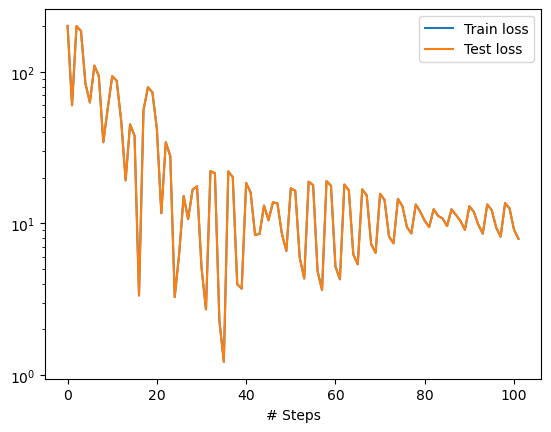

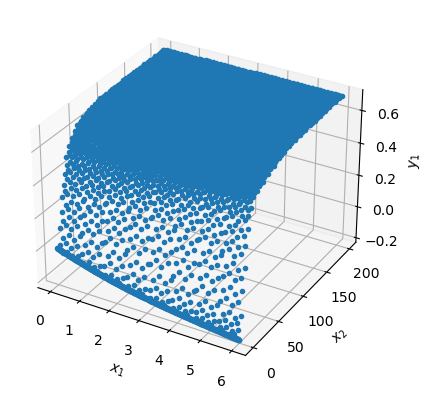

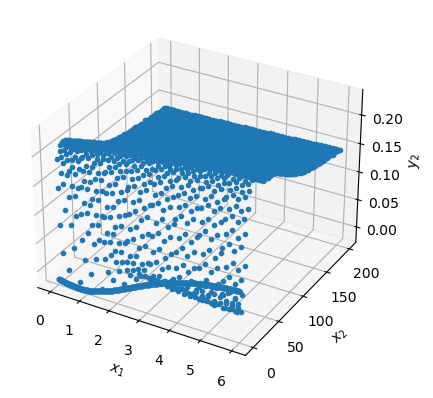

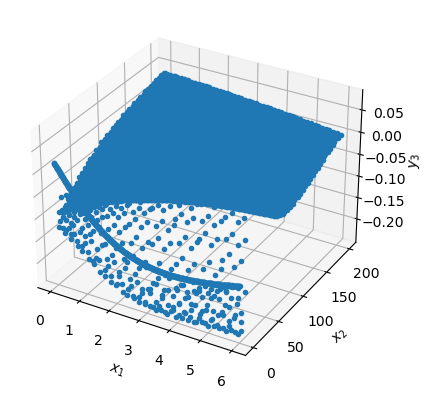

/usr/local/home/cyan3/Dev/jim/gradschool/231/research/wass_1d_torch_scratch0_model-101.pt


In [23]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
model_path = model.save(ck_path)
print(model_path)

In [24]:
params = {'backend': 'ps',
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'legend.handlelength': 1,
          'legend.borderaxespad': 0,
          'font.family': 'serif',
          'font.serif': ['Computer Modern Roman'],
          'ps.usedistiller': 'xpdf',
          'text.usetex': True,
          # include here any neede package for latex
          'text.latex.preamble': [r'\usepackage{amsmath}'],
          }
plt.rcParams.update(params)
plt.style.use('seaborn-white')

loss_loaded [[  0.      0.02    0.001 ...   0.278 200.353   0.193]
 [  1.      0.015   0.001 ...   0.238  59.791   0.146]
 [  2.      0.011   0.001 ...   0.207 199.939   0.174]
 ...
 [ 99.      0.      0.    ...   0.     12.537   0.004]
 [100.      0.      0.    ...   0.      9.073   0.005]
 [101.      0.      0.    ...   0.      7.919   0.004]]
saved plot


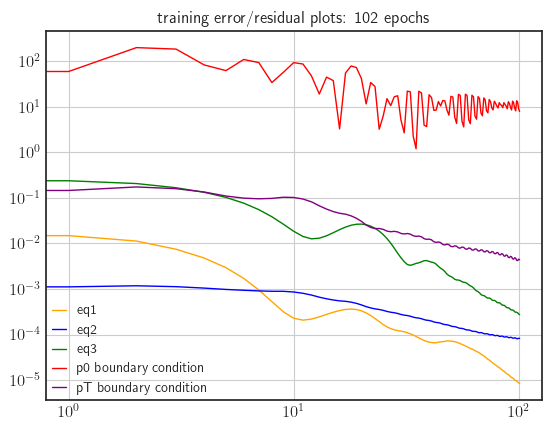

In [25]:
# 16 plot loss

loss_loaded = np.genfromtxt('./loss.dat')

print("loss_loaded", loss_loaded)

# import ipdb; ipdb.set_trace();

# [0] epoch
# [1] y1, psi, hjb
# [2] y2, rho, plank pde
# [3] rho0, initial
# [4] rhoT, terminal

epoch = loss_loaded[:, 0]
y1_psi_hjb = loss_loaded[:, 1]
y2_rho_plankpde = loss_loaded[:, 2]
loss3 = loss_loaded[:, 3]
rho0_initial = loss_loaded[:, 4]
rhoT_terminal = loss_loaded[:, 5]

fig, ax = plt.subplots()


line1, = ax.plot(epoch, y1_psi_hjb, color='orange', lw=1, label='eq1')
line2, = ax.plot(epoch, y2_rho_plankpde, color='blue', lw=1, label='eq2')
line2, = ax.plot(epoch, loss3, color='green', lw=1, label='eq3')
line3, = ax.plot(epoch, rho0_initial, color='red', lw=1, label='p0 boundary condition')
line4, = ax.plot(epoch, rhoT_terminal, color='purple', lw=1, label='pT boundary condition')

ax.grid()
ax.legend(loc="lower left")
ax.set_title('training error/residual plots: %d epochs' % (len(epoch)))
ax.set_yscale('log')
ax.set_xscale('log')

plot_fname = "%s/loss.png" % (os.path.abspath("./"))
plt.savefig(plot_fname, dpi=300)
print("saved plot")

plt.show()

In [26]:
T_IDX = 1
X_IDX = 0
EQ_IDX = 3

In [27]:
# 18 load test data

test = np.genfromtxt('./test.dat')
# test_timesorted = test[test[:, 3].argsort()]
# sort AGAIN by output because a lot of samples @ t=0, t=5
ind = np.lexsort((test[:,EQ_IDX],test[:,T_IDX])) # sorts by [1] (t) then by [3] (rho_0)
test_timesorted = test[ind]
source_t = test_timesorted[:, 1]

print(test_timesorted)

[[  0.715   0.     -0.04   -0.023  -0.044]
 [  0.727   0.     -0.041  -0.023  -0.045]
 [  0.703   0.     -0.04   -0.023  -0.043]
 ...
 [  5.755 200.      0.704   0.144   0.002]
 [  5.878 200.      0.704   0.144   0.001]
 [  6.    200.      0.704   0.144   0.   ]]


[[ 0.     0.     0.002 -0.018  0.02 ]
 [ 1.98   0.    -0.102 -0.004 -0.121]
 [ 4.98   0.    -0.189  0.056 -0.143]
 ...
 [ 0.703  0.    -0.04  -0.023 -0.043]
 [ 5.578  0.    -0.202  0.06  -0.135]
 [ 2.578  0.    -0.125  0.011 -0.14 ]]


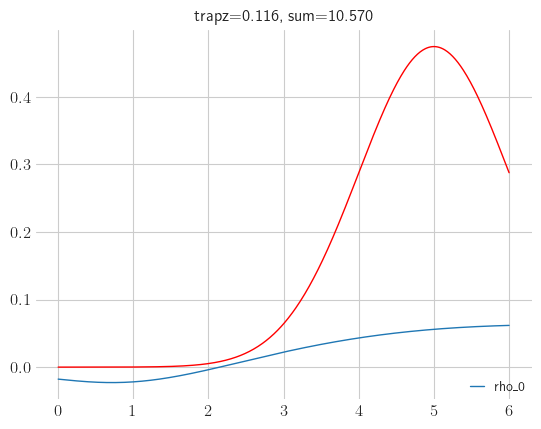

In [28]:
# 35 plot rho at t=5, t=0

target_t = 0.0

test_timesorted = test[test[:, T_IDX].argsort()]
timesorted = test_timesorted[:, T_IDX]
test_ti = test_timesorted[np.where(np.abs(timesorted - target_t) < 1e-8), :][0] # 2k

print(test_ti)

ind = np.lexsort((test_ti[:,EQ_IDX],test_ti[:,0])) # sorts by [1] (t) then by [3] (rho_0)
test_ti = test_ti[ind]

s1 = np.trapz(test_ti[:,EQ_IDX], axis=0, x=test_ti[:,X_IDX])
s2 = np.sum(test_ti[:,EQ_IDX])

fig = plt.figure(1)
ax1 = plt.subplot(111, frameon=False)
# ax1.set_aspect('equal')
ax1.grid()
ax1.set_title('trapz=%.3f, sum=%.3f' % (s1, s2))

ax1.plot(
    test_ti[:, 0],
    test_ti[:, EQ_IDX],
    linewidth=1,
    label='rho_0')
ax1.legend(loc='lower right')

test_rho0=pdf1d(test_ti[:, 0], 5.0, 1.0).reshape(test_ti.shape[0],1)
ax1.plot(
    test_ti[:, 0],
    test_rho0,
    c='r',
    linewidth=1,
    label='rho_0')

plt.show()

In [ ]:
# 35 plot rho at t=5, t=0

target_t = 0.0

test_timesorted = test[test[:, T_IDX].argsort()]
timesorted = test_timesorted[:, T_IDX]
test_ti = test_timesorted[np.where(np.abs(timesorted - target_t) < 1e-8), :][0] # 2k

ti_rho_opt = test_ti[:, ]

ti_rho_opt = np.where(ti_rho_opt<0, 0, ti_rho_opt)

ti_x1_x2_x3 = test_ti[:, 0:3]

####################################################################

d = 0.0
x1 = np.linspace(state_min - d, state_max + d, N)
x2 = np.linspace(state_min - d, state_max + d, N)
x3 = np.linspace(state_min - d, state_max + d, N)
X1, X2, X3 = np.meshgrid(x1,x2,x3,copy=False) # each is NxNxN

rho_opt = np.zeros((N,N,N))

closest_1 = [(np.abs(x1 - ti_x1_x2_x3[i, 0])).argmin() for i in range(ti_x1_x2_x3.shape[0])]
closest_2 = [(np.abs(x2 - ti_x1_x2_x3[i, 1])).argmin() for i in range(ti_x1_x2_x3.shape[0])]
closest_3 = [(np.abs(x3 - ti_x1_x2_x3[i, 2])).argmin() for i in range(ti_x1_x2_x3.shape[0])]

# some transposing going on in some reshape
# swapping closest_1/2 works well
rho_opt[closest_1, closest_2, closest_3] = ti_rho_opt

####################################################################

# RHO_OPT = gd(
#   (ti_x1_x2_x3[:, 0], ti_x1_x2_x3[:, 1], ti_x1_x2_x3[:, 2]),
#   ti_rho_opt,
#   (X1, X2, X3),
#   method='linear')

####################################################################

x1_marginal = np.array([
    np.trapz(
        np.array([
            np.trapz(rho_opt[j, i, :], x=x3) # x3 slices for one x2 => R
            for i in range(len(x2))]) # x3 slices across all x2 => Rn
        , x=x2) # x2 slice for one x1 => R
for j in range(len(x1))])

x2_marginal = np.array([
    np.trapz(
        np.array([
            np.trapz(rho_opt[i, j, :], x=x3) # x3 slices for one x1 => R
            for i in range(len(x1))]) # x3 slices across all x1 => Rn
        , x=x1) # x1 slice for one x2 => R
for j in range(len(x2))])

x3_marginal = np.array([
    np.trapz(
        np.array([
            np.trapz(rho_opt[i, :, j], x=x2) # x2 slices for one x1 => R
            for i in range(len(x1))]) # x2 slices across all x1 => Rn
        , x=x1) # x1 slice for one x3 => R
for j in range(len(x3))])

####################################################################

# normalize all the pdfs so area under curve ~= 1.0
x1_pdf_area = np.trapz(x1_marginal, x=x1)
x2_pdf_area = np.trapz(x2_marginal, x=x2)
x3_pdf_area = np.trapz(x3_marginal, x=x3)
print("prior to normalization: %.2f, %.2f, %.2f" % (
    x1_pdf_area,
    x2_pdf_area,
    x3_pdf_area))

x1_marginal /= x1_pdf_area
x2_marginal /= x2_pdf_area
x3_marginal /= x3_pdf_area

print(x1_marginal.shape)

x1_pdf_area = np.trapz(x1_marginal, x=x1)
x2_pdf_area = np.trapz(x2_marginal, x=x2)
x3_pdf_area = np.trapz(x3_marginal, x=x3)
print("after to normalization: %.2f, %.2f, %.2f" % (
    x1_pdf_area,
    x2_pdf_area,
    x3_pdf_area))

fig = plt.figure(1)
ax1 = plt.subplot(131, frameon=False)
# ax1.set_aspect('equal')
ax1.grid()
ax1.set_title('x1 marginal')

ax2 = plt.subplot(132, frameon=False)
# ax2.set_aspect('equal')
ax2.grid()
ax2.set_title('x2 marginal')

# ax3 = plt.subplot(133, frameon=False)

ax3 = plt.subplot(133, frameon=False)
# ax3.set_aspect('equal')
ax3.grid()
ax3.set_title('x3 marginal')

colors="rgbymkc"

i = 0
t_e = 0
ax1.plot(x1,
    x1_marginal,
    colors[i % len(colors)],
    linewidth=1,
    label=t_e)
ax1.legend(loc='lower right')

ax2.plot(x2,
    x2_marginal,
    colors[i % len(colors)],
    linewidth=1,
    label=t_e)
ax2.legend(loc='lower right')

ax3.plot(x3,
    x3_marginal,
    colors[i % len(colors)],
    linewidth=1,
    label=t_e)
ax3.legend(loc='lower right')

fig.suptitle('t=%.2f' % (target_t), fontsize=16)

plt.show()

In [ ]:
rv0 = multivariate_normal([mu_0, mu_0, mu_0], sigma_0 * np.eye(3))
rvT = multivariate_normal([mu_T, mu_T, mu_T], sigma_T * np.eye(3))

def pdf3d_0(x,y,z):
    return rv0.pdf(np.hstack((x, y, z)))

def pdf3d_T(x,y,z):
    return rvT.pdf(np.hstack((x, y, z)))

print(time.time())

In [ ]:
# 3d linprog example, with bounds

rho_0=pdf3d_0(x_T,y_T,z_T).reshape(len(x_T),1)
rho_T=pdf3d_T(x_T,y_T,z_T).reshape(len(x_T),1)

# very important to make it solvable
rho_0 = np.where(rho_0 < 0, 0, rho_0)
rho_0 = rho_0 / np.sum(rho_0)

rho_T = np.where(rho_T < 0, 0, rho_T)
rho_T = rho_T / np.sum(rho_T)

res = linprog(
    cvector,
    A_eq=A,
    b_eq=np.concatenate((rho_0, rho_T), axis=0),
    options={"disp": True},
    bounds=[(0, np.inf)], 
    # x >= 0
    # x < inf
)

if res.fun is not None:
    print("mu_0 %.3f to mu_T %.3f" % (mu_0, mu_T))
    print(np.sqrt(res.fun))

In [ ]:
def penalty(xpdf):
    p1 = 10 * (xpdf<0).sum()
    
    t = np.trapz(xpdf, axis=0)[0]
    p2 = 10 * np.abs(t - 1)
    return p1 + p2

def WASS(y_true, y_pred):
    xpdf = y_pred.numpy()

    xpdf = np.where(xpdf < 0, 0, xpdf)
    if np.sum(xpdf) > 1e-8:
        xpdf = xpdf / np.sum(xpdf)

    res = linprog(
        cvector,
        A_eq=A,
        b_eq=np.concatenate((xpdf, rho_0_1d), axis=0),
        options={"disp": False},
        bounds=[(0, np.inf)],
    )
    
    # we are cheating here, we are using tf.reduce_sum
    # so that tf system will like our output 'type'
    # but we are 0'ing the sum and adding our scalar cost
    cand = tf.reduce_sum(y_pred) * 0.0
    
    if res.fun is None:
        return np.inf + cand
    else:
        lin = np.sqrt(res.fun)
        pen = penalty(xpdf)
#         print("trapz %.3f, count %d, pen %.3f, lin %.3f" % (
#             np.trapz(xpdf, axis=0)[0],
#             (xpdf<0).sum(),
#             pen,
#             lin))
        return lin + cand + pen

def WASS2(y_true, y_pred):
    loss = tf.py_function(
        func=WASS,
        inp=[y_true, y_pred],
        Tout=tf.float32
    )
    return loss

def Z(y_true, y_pred):
#     xpdf = y_pred.numpy()
    
#     t = np.trapz(xpdf, axis=0)[0]
#     p2 = 10 * np.abs(t - 1)
    
    cand = tf.abs(1 - tf.reduce_sum(y_pred))
    
    cand = cand + 100 * (0 - tf.reduce_min(y_pred))

    return cand

def Z2(y_true, y_pred):
    loss = tf.py_function(
        func=Z,
        inp=[y_true, y_pred],
        Tout=tf.float32
    )
    return loss

print(time.time())